Universidad de Costa Rica  <br>
CI-0148 Aprendizaje Máquina <br>
Período: 2022-I <br>
Docente: Pablo Sauma Chacón <br>
Estudiante: Jose Pablo Mora Villalobos <br>
Carné: B85326 <br>
***

# Laboratorio 3

Objetivo: Familiarizar al estudiante con la creación y el uso de regresiones lineales. Así como las diferentes métricas que existen para medir el rendimiento de los modelos implementados.

[Descripción del laboratorio](https://docs.google.com/document/d/1a2B7OMv4_4O8kIb1mN289Eq3_6JPQBN-wTRe5xT-vZc/edit)

## 1. Importar el dataset

EL dataset se importa con la librería `pandas`. Además se importan la librerías `numpy` para diversas operaciones. En este caso no es necesario aplicar ninguna técnica de limpieza de datos sobre el dataset.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("fish_perch.csv",na_values=None)
df.head()


,Weight,Length1,Length2,Length3,Height,Width
0,5.9,7.5,8.4,8.8,2.1120,1.4080
1,32.0,12.5,13.7,14.7,3.5280,1.9992
2,40.0,13.8,15.0,16.0,3.8240,2.4320
3,51.5,15.0,16.2,17.2,4.5924,2.6316
4,70.0,15.7,17.4,18.5,4.5880,2.9415


# 2. Cálculo de funciones de error y métrica de rendimiento

Para que el algoritmo de regresión lineal funcione, se necesita alguna función de error, en este caso se van a utilizar error mínimo cuadrado `MSE` y error mínimo absoluto `MAE`. Además, para determinar el rendimiento del modelo se utiliza la función `score()` que retorna la métrica de errores cuadrados $R^2$

In [3]:
def MSE(y_true, y_predict):
    return ((y_true - y_predict)**2).mean()

def MAE(y_true, y_predict):
    return abs((y_true - y_predict)).mean()

def score(y_true, y_predict):
    SS_reg = ((y_true - y_predict)**2).sum()
    SS_tot = ((y_true - y_true.mean())**2).sum()
    return 1-SS_reg/SS_tot

# 3. Modelo de regresión lineal

Para crear los modelos de regresión lineal se utiliza una clase llamada `LinearRegression`. Esta clase cuenta con los métodos `fit()` para entrenar el modelo con un algún conjunto de datos. Un método `predict()` para indicar los valores de la variable de respuesta para un grupo de datos de entrada a partir de los valores del modelo. También tiene un par de métodos privados para el funcionamiento de la clase: `__reg_func()` y `__derivative()`

In [35]:
class LinearRegression:
    '''
    Implementación del modelo de regresión lineanl.
    '''

    def fit(self, x, y, 
            max_epochs=100, 
            threshold=0.01, 
            learning_rate=0.001, 
            momentum=0, 
            decay=0, 
            error='mse', 
            regularization='none', 
            lambda_=0,
            verbose=False,
            vebose_val=100):
        '''
        Entrena el modelo linear a partir de un conjunto de datos.

        Parámetros
        ----------

        x : Arreglo o matriz de forma (n_muestras, n_variables)
            Conjunto de datos de entrada para entrenamiento
 
        y : Arreglo de forma (n_muestras, )
            Conjutno de datos de salida
        
        max_epochs : Entero positivo. Valor por defecto: 100
            Cantidad de iteraciones que dura el entrenamiento

        threshold : Entero positivo. Valor por defecto: 0.01
            Valor mínimo de cambio de error entre iteraciones.
        
        learning_rate : Entero positivo menor a 1. Valor por defecto: 0.001
            Tasa de aprendizaje
        
        momentum : Entero positivo menor a 1 y mayor o igual a 0. Valor por defecto: 0
            Inercia. Se utiliza para cambiar los valores de c con respecto a la iteración anterior.

        decay : Entero positivo menor a 0.01. Valor por defecto: 0
            Taza de decaimiento. Modifica el valor de learning_rate en cada iteración.
        
        error : String. Valores aceptados {mse, mae}. Valor por defecto: mse
            Función de error del entrenamiento.
        
        regularization : String. Valores aceptados {l1, lasso, l2, ridge, elastic-net, none}. Valor por defecto: none
            Técnica de regularización usada para alterar la función de error. l1 es igual a lasso, l2 es igual a ridge.
            Cualquier otro valor que sea los aceptados se consideran como none.
        
        lambda_ : Entero entre 0 y 1. Valor por defecto: 0
            Valor que se utiliza para la regularización.

        verbose :  Booleano. Valor por defecto: Falso
            Mostrar el error en las épocas.
        
        verbose_val : Entero positivo mayor a 0. Valor por defecto: 100
            Mostrar el error cada cierto número de épocas.
        '''

        error_func = {'mse': MSE, 'mae': MAE} 
        epoch = 0

        x = np.insert(np.asarray(x), 0, 1, axis=1)
        n = x.shape[1]

        self.c = np.random.uniform(0,1,size= n)
        self.lambda_ = lambda_
        dC = np.zeros((n,))
        change = True
        self.error_value = np.inf

        while epoch != max_epochs and change == True:

            dCt = dC 
            dC = self.__derivative(error,regularization,x,y,n)
            self.c = self.c - learning_rate * (dC + momentum * dCt)

            learning_rate = learning_rate/(1+decay)
            new_error_val = error_func[error](y,x @ self.c)
            if self.error_value - new_error_val < threshold:
                change = False  
            else:
                self.error_value = new_error_val
            if verbose and epoch % vebose_val == 0:
                print('Epoch: {}\tError: {}'.format(epoch,self.error_value))
            epoch+=1

    def predict(self,x):
        '''
        Predice los resultados de un conjunto de datos con respecto a los 
        valores generados durante el entrenamiento.

        Parámetros
        ----------

        x : Arreglo o matriz de forma (n_muestras, n_variables)
            Conjunto de datos sobre los cuales se quiere hacer una predicción.

        Retorno
        -------

        predicción :  Arreglo de forma (n_muestras, )
            Contiene los resultados de aplicar la regresión lineal sobre cada entrada de x.
        '''
        index_list = x.index #Índices originales del dataset
        x = np.insert(np.asarray(x), 0,1, axis=1)   # se añade una columna de 1's que correponde la bias
        return pd.Series((x @ self.c), index=index_list)

    def __reg_func(self, regulator):
        '''
        Genera el valor de la técnica de regularización para el cálculo de la derivada del error.

        Parámetros
        ----------
        
        regulator : String. Valores aceptados {l1, lasso, l2, ridge, elastic-net, none}.
            Técnica de regularización usada para alterar la función de error. l1 es igual a lasso, l2 es igual a ridge.
            Cualquier otro valor que sea los aceptados se consideran como none.
        
        Retorno
        -------

        Valor de regularización : flotante, vector de flotantes
            Depende del regularizador. `l1` y `lasso` retornan lambda (flotante).
            `l2` y `ridge` retornan 2 * lambda * c (vector).
            `elastic-net` retorna una combinación de l1 y l2.
            Cualquier otro valor de regularización retorna 0.
        '''
        if regulator == 'l1' or regulator == 'lasso':
            return self.lambda_
        elif regulator == 'l2' or regulator == 'ridge':
            return self.lambda_*self.c*2
        elif regulator == 'elastic-net':
            return self.lambda_ + (1 - self.lambda_) * self.c * 2
        else:
            return 0

    def __derivative(self, reg_func, reg, x, y, n):
        '''
        Genera la derivada parcial de la función de error para cada valor de c

        Parámetros
        ----------

        n : Entero
            Cantidad de datos en x
        
        reg_func : String. Valores aceptados {mse, mae}. Valor por defecto: mse
            Función de error del modelo.
        
        reg : String. Valores aceptados {l1, lasso, l2, ridge, elastic-net, none}.
            Ver __reg_func().
        
        Retorno
        -------

        Derivada parcial : Arreglo de forma (n_variables_de_x, )
            Valores de la derivada parcial para cada valor de c (ver fit()).
            Además se toma en cuenta la técnica de regularización.
        '''
        if reg_func == 'mse':
            # Este for no es necesario pero genera el mismo vector que el retorno
            # for i in range(dc.size):
            #     dc[i] = -2*(np.matmul(x[:,i],(y - x @ c)))/c.shape
            return (-2 / n) * ((y-(x @ self.c)).T @ x) + self.__reg_func(reg)
        elif reg_func == 'mae':
            return ((x @ self.c - y).T @ x).T / n + self.__reg_func(reg)



# 4. Pruebas sobre el modelo

Para mostrar el funcionamiento del modelo, se divide el dataset en partes para entrenamiento y para pruebas. Para esto se utiliza el método `train_test_split()` de la librería `sklearn`.
Primero se crea el modelo, luego se entrena con algunos hiperparámetros que no sean los predeterminados y luego se predice un conjunto del dataset para determinar su rendimiento con `score()`. El error se muestra cada 1000 iteraciones.

In [36]:
        
from sklearn.model_selection import train_test_split

y = df['Weight']
x = df.drop(columns=['Weight'])

X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.75, test_size=0.25, random_state=21)

lr = LinearRegression()
lr.fit(X_train,y_train,
       max_epochs = 10000, 
       momentum = 1e-5,
       decay = 1e-7,
       learning_rate = 1e-5,
       regularization = 'l1',
       lambda_ = 0.1,
       threshold = 0,
       error = 'mse',
       verbose=True,
       vebose_val=1000)


pred = lr.predict(X_test)
print('R2: ',score(y_test,pred))


Epoch: 0	Error: 117889.51343693906
Epoch: 1000	Error: 39981.63158854939
Epoch: 2000	Error: 37101.35470420174
Epoch: 3000	Error: 34548.202603926875
Epoch: 4000	Error: 32282.21980640329
Epoch: 5000	Error: 30268.421749247915
Epoch: 6000	Error: 28476.173138055867
Epoch: 7000	Error: 26878.644179919807
Epoch: 8000	Error: 25452.334934179933
Epoch: 9000	Error: 24176.659238929667
R2:  0.7083928753087174


Con los valores de los hiperparámetros que se usaron se logró conseguir un 0.71 de $R^2$, lo que indica que el modelo explica el 71% del comportamiento de los datos. Con algunas pruebas extra que he hecho, he visto que la mejor forma de aumentar el rendimiento del modelo y reducir el error es aumentando el número de iteraciones a más de 100000.

# 5. Modelo de regresión lineal de sklearn

Por otra parte, se puede considerar el desempeño del modelo creado con uno de `sklearn`. La librería cuenta con su propio modelo con los método `fit()` y `predict()`, similares a los hechos en este laboratorio.

In [40]:

from sklearn.linear_model import LinearRegression as LinearReg
lr2 = LinearReg()
lr2.fit(X_train, y_train)
pred2 = lr2.predict(X_test)

print('R cuadrado')
print('Modelo local:\t', score(y_test,pred))
print('Modelo sklearn:\t', score(y_test,pred2))
print(pd.DataFrame({'Valor real':y_test,'Local':pred,'sklear':pred2}))


R cuadrado
Modelo local:	 0.7083928753087174
Modelo sklearn:	 0.9152645549350648
    Valor real       Local      sklear
7         80.0  266.595503   90.864572
51      1100.0  727.569623  836.432721
47       850.0  702.057279  824.695681
25       145.0  310.561471  213.908514
14       120.0  284.075802  157.191689
2         40.0  161.620886  -61.129371
23       170.0  301.937636  198.889954
31       260.0  364.937404  301.739046
17       135.0  275.272921  160.894758
53      1100.0  737.495624  882.500422
30       300.0  491.330910  434.870044
21       145.0  281.139665  175.665725
19       130.0  275.866364  171.151992
11       115.0  273.235922  138.417157


El modelo de `sklearn` logró un rendimiento de 92% con la métrica de R cuadrado, muy superior a los alcanzados con el modelo local. En cuanto a las predicciones, se puede notar que el modelo se `sklearn` consigue obtener valores más altos cuando lo requiere, como en las observaciones 51 y 53 donde alcanzó el valor de 800, sin embargo, es posible que consiga valores negativos, como en la observación 2. El modelo local brinda un conjunto de datos más compacto, con mínimos más altos y máximos más bajos. Esto es en parte también porque el modelo local solo logra un rendimiento del 72%.

# 6. Pruebas de hiperparámetros

Para probar ciertas combinaciones de hiperparámetros se puede utilizar el siguiente método. Está pensado para ser utilizado con el modelo de regresión lienal creado en este laboratorio. Recibe una diccionario con los parámetros en orden como llave y una lista con los valores de cada hiperparámetro. Imprime la cantidad de modelos que se entrenamientos que se realizan por cada combinación de hiperparámetros, y al final se muestra la mejor combinación con la métrica de `score()`. Además, retorna un vector con las todas las combinaciones y su respectivo valor de `score()`.

In [44]:
import itertools as it

def grid_search(param_grid):         
    combinations = it.product(*(param_grid[Name] for Name in param_grid))
    score_ = 0
    scores = []
    best_i = ()
    n_comb = 0
    c = list(combinations)
    print('Total de comb: ', len(c))
    lr = LinearRegression()
    for i in c:
        if n_comb % 100 == 0:
            print('Comb analizadas: ', n_comb)
        n_comb += 1
        lr.fit(X_train,y_train,
        max_epochs=i[0], 
        learning_rate=i[1],
        momentum=i[2],
        decay=i[3],
        error=i[4],
        regularization=i[5],
        lambda_=i[6])
        new_score_ = score(y_test,lr.predict(X_test))
        if (score_ < new_score_):
            score_ = new_score_
            best_i = i
        scores.append([i,new_score_])
    print('Mejor combinación: ',best_i, score_)
    return (scores)


In [45]:
param_grid = {
    'max_epochs':[1000,10000], 
    'learning_rate':[1e-5,1e-7],
    'momentum':[0,1e-5,1e-10],
    'decay':[0,1e-5,1e-10],
    'error':['mse','mae'],
    'regularization':['l1','l2','elastic-net','none'],
    'lambda_':[0.1,0.01]
    }

scores = grid_search(param_grid)

Total de comb:  576
Comb analizadas:  0
Comb analizadas:  100
Comb analizadas:  200
Comb analizadas:  300
Comb analizadas:  400
Comb analizadas:  500
Mejor combinación:  (10000, 1e-05, 0, 0, 'mse', 'l1', 0.1) 0.7093159306169738


Por cuestiones de tiempo no se realizaron pruebas para valores de `max_epochs` mayores a 10000. De momento no se probó con ningún valor de `threshold` distinto del predeterminado. Al terminar las se consiguió que la mejor combinación de hiperparámetros es de `max_epochs` 10000, `learning_rate` 1e-05, `momentum` 0, `decay` 0, `error` 'mse', `regularization` 'l1' y `lambda_` 0.1. En general los mejores valores para este modelo fueron los que se dan por defecto, excepto en el caso de `max_epochs`, `learning_rate`, y `regularization`. El valor obtenido con la métrica es de 71% todavía relativamente bajo comparado con el `sklearn`.

count    576.000000
mean       0.533353
std        0.077106
min        0.436853
25%        0.507913
50%        0.532052
75%        0.539201
max        0.709316
Name: Scores, dtype: float64


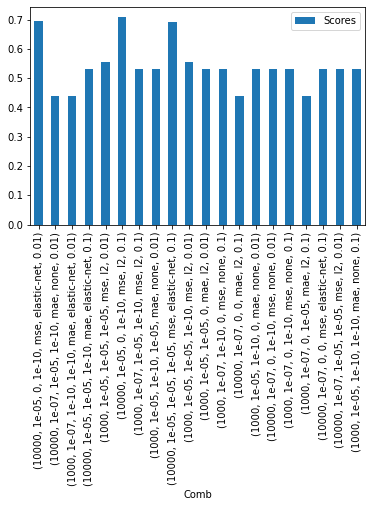

In [72]:
df = pd.DataFrame(scores, columns =['Comb', 'Scores'])
print(df['Scores'].describe())
df.sample(20).plot(x ='Comb', kind='bar')
plt.show()


Con respecto a los datos obtenidos con `grid_search()`, se tuvo una media de 53% para el $R^2$. Además, varios modelos alcanzaron el %70 de $R^2$. Es difícil poder observar si alguno de los parámetros tuvo algún efecto en este resultado, pero parece ser que la regularización `mae` hace que los valores de $R^2$ sean menores, esto porque algunas combinaciones que usaron `mae` con 10000 iteraciones son peores incluso que algunos de `mse` con 1000 iteraciones. Pero eso es solo observando algunos de los datos y no el total de los generados.

# 7. Mejoramiento del rendimiento

Para mostrar el rendimiento del modelo con más épocas, se va a realizar una corrida con 200000 iteraciones y los valores del mejor modelo obtenido en la sección anterior.

In [75]:
lr = LinearRegression()
lr.fit(X_train,y_train,
       max_epochs = 200000, 
       learning_rate = 1e-05,
       momentum = 0,
       decay = 0,
       error = 'mse',
       regularization = 'l1',
       lambda_ = 0.1,
       threshold = 0,
       verbose=True,
       vebose_val=20000)


pred = lr.predict(X_test)
print('R2: ',score(y_test,pred))

Epoch: 0	Error: 119369.17591248677
Epoch: 20000	Error: 16197.146934232056
Epoch: 40000	Error: 11659.009181901854
Epoch: 60000	Error: 9791.37952174737
Epoch: 80000	Error: 8717.385050545328
Epoch: 100000	Error: 8038.023969367352
Epoch: 120000	Error: 7581.83438364001
Epoch: 140000	Error: 7258.696229453165
Epoch: 160000	Error: 7018.814166200889
Epoch: 180000	Error: 6833.766188020392
R2:  0.8976715894161273


En este caso se consiguió una métrica de 0.90 para el $R^2$. Mejoró sustancialmente y está similar al obtenido con el modelo de `sklearn`. Además se logró reducir el error a menos de 6833.77 (menor porque no se muestran los valores después de la iteración 180000). Todavía se podría determinar si más iteraciones dan un mejor resultado, y con cuál combinación de hiperparámetros, pero esta búsqueda puede ser muy exhaustiva y por el momento es suficiente con el resultado encontrado.

# 8. Cambio del dataset de entrenamiento

Por ultimo, para ver el comportamiento del modelo con distintas particiones del dataset, se va a utilizar una semilla distinta durante la división del dataset. Hasta ahora solo se ha utilizado la partición del dataset con el método `train_test_split()` de `sklearn` y con la semilla 21, sin embargo, ahora se van a realizar diversas pruebas con otras semillas elegidas al azar y con el modelo anterior, pero con 100000 iteraciones. 

In [82]:
df = pd.read_csv("fish_perch.csv",na_values=None)
y = df['Weight']
x = df.drop(columns=['Weight'])

seeds = np.random.randint(0,100,8)
for seed in seeds:
       X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.75, test_size=0.25, random_state=seed)
       lr = LinearRegression()
       lr.fit(X_train,y_train,
              max_epochs = 100000, 
              learning_rate = 1e-05,
              momentum = 0,
              decay = 0,
              error = 'mse',
              regularization = 'l1',
              lambda_ = 0.1,
              threshold = 0)


       pred = lr.predict(X_test)
       print('Semilla: {} R2: {}'.format(seed,score(y_test,pred)))

Semilla: 8 R2: 0.8951606389892417
Semilla: 14 R2: 0.8961516577560513
Semilla: 62 R2: 0.920510533313193
Semilla: 77 R2: 0.8969116621387921
Semilla: 63 R2: 0.8863424648682727
Semilla: 84 R2: 0.8190715814907411
Semilla: 38 R2: 0.9309274840619193
Semilla: 59 R2: 0.9250241146448245


En este caso se puede ver que las diferencias de $R^2$ pueden fluctuar bastante. En algunos casos se logra un valor de hasta 93%, sin embargo pueden haber casos donde el modelo se comporta mucho peor, llegando hasta el 82%. Al cambiar el conjunto de datos de entrada, a pesar de usar los mismos hiperparámetros para el modelo, este se ajusta mejor o peor a los datos, y por lo tanto se consiguen distintos valores al medir su rendimiento. Entonces la selección del dataset de prueba y entrenamiento también es importante de tomar en cuenta cuando se crean y analizan modelos.